# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 3: Baseline Model

This notebook contains code to establish a baseline model that can address our problem statement of having an accuracy that is at least 10% better than the baseline accuracy of `0.287`.

<div class="alert alert-block alert-info">
Note: This notebook takes approx. 4 h 25 min to run on a PC with an Intel i7-8565U CPU, 16GB of RAM and Windows 10 operating system.
</div>

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)
- [Splitting of data into Predictor and Target Dataframes](#Splitting-of-data-into-Predictor-and-Target-Dataframes)
- [Creation of (Inner) Training and Validation Datasets](#Creation-of-(Inner)-Training-and-Validation-Datasets)
- [Generation of weighted word counts using TfidfVectorizer](#Generation-of-weighted-word-counts-using-TfidfVectorizer)
- [Combining weighted word counts with dummy columns](#Combining-weighted-word-counts-with-dummy-columns)
- [Handling of imbalanced classes](#Handling-of-imbalanced-classes)
- [Scaling the data for PCA](#Scaling-the-data-for-PCA)
- [Dimensionality reduction using PCA](#Dimensionality-reduction-using-PCA)
- [Randomised search for optimal classifier parameters](#Randomised-search-for-optimal-classifier-parameters)
- [Selection of Baseline Model](#Selection-of-Baseline-Model)
- [Further Exploration of Baseline Model](#Further-Exploration-of-Baseline-Model)
    - [Logistic Regression Coefficients](#Logistic-Regression-Coefficients)
    - [ROC curves and metrics for Validation Dataset](#ROC-curves-and-metrics-for-Validation-Dataset)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Comparison of Frequency Distributions](#Comparison-of-Frequency-Distributions)
- [Summary of Baseline Model](#Summary-of-Baseline-Model)
- [Data Export (for Kaggle Submission)](#Data-Export-(for-Kaggle-Submission))

In [473]:
# For tracking the execution time for the entire notebook
import time
import datetime
now = datetime.datetime.now()
print ("Started executing notebook at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
notebook_start = time.time()

Started executing notebook at: 2020-04-15 16:52:37


---

## Importing of Libraries

In [539]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from itertools import cycle
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Additional general purpose libraries
from tabulate import tabulate

# scikit-learn machine learning libraries
from sklearn import linear_model, metrics, svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_curve, auc, f1_score, balanced_accuracy_score,\
    plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

# Used for visualising specific trees
from sklearn.tree import export_graphviz
from subprocess import call 
from IPython.display import Image

# Used for oversampling
from imblearn.over_sampling import ADASYN

# Used for forward neural network classifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers

# For deployment of model
from joblib import dump

# Initialise random seeed for more consistent results
from numpy.random import seed
seed(42)

## Data Import

In [475]:
# Import 'train_prep' and 'test_prep' datasets
# We use the 'keep_default_na' option to False to ensure that pandas does not re-introduce missing values
train = pd.read_csv("../assets/train_prep.csv", keep_default_na=False)
test = pd.read_csv("../assets/test_prep.csv", keep_default_na=False)

In [476]:
train.shape, test.shape

((3321, 4325), (986, 4324))

In [477]:
train.head(2)

id  class  \
0   0      1   
1   1      2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [478]:
test.head(2)

id  \
0   1   
1   2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Splitting of data into Predictor and Target Dataframes

In [479]:
X = train[[i for i in train.columns if i not in ['id', 'class']]]
y = train['class']

In [480]:
X.shape, y.shape

((3321, 4323), (3321,))

In [481]:
# Save copies of the original X and y dataframes so that we can try different word embeddings as needed
X_original = X.copy()
y_original = y.copy()

In [482]:
X_test = test.drop(['id'], axis=1)

In [483]:
X_test.shape

(986, 4323)

## Creation of (Inner) Training and Validation Datasets

From our single training data set (X and y) we will create two separate datasets:
- (Inner) Training Dataset: this will be used to train our models (this will take 75% of the original training dataset)
- Validation Dataset: this will be used to validate our trained models (e.g. check for overfitting) (this will take 25% of our total 'posts' dataset

To create our datasets, we use train_test_split with the stratify option to ensure a consistent mix of values for the target feature within the created datasets.

In [484]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [485]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2490, 4323), (2490,), (831, 4323), (831,))

In [486]:
# Reset the indices to prevent spurious rows from appearing later during merging
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

## Generation of weighted word counts using TfidfVectorizer

For our baseline model, we use the TfidfVectorizer from sklearn, which creates weighted word frequencies in the descriptive text strings. The weights are based on each word's inverse document frequency (i.e. heavier weights are assigned to words that are less frequent).

In [487]:
# Instantiate a CountVectorizer object
tvec = TfidfVectorizer()

In [488]:
%%time
X_train_tvec = tvec.fit_transform(X_train['text'])
X_val_tvec = tvec.transform(X_val['text'])
X_test_tvec = tvec.transform(X_test['text'])

Wall time: 20.1 s


In [489]:
X_train_tvec.shape, X_val_tvec.shape, X_test_tvec.shape

((2490, 72190), (831, 72190), (986, 72190))

In [490]:
X_train_tvec_df = pd.DataFrame(X_train_tvec.toarray(), columns=tvec.get_feature_names())
X_val_tvec_df = pd.DataFrame(X_val_tvec.toarray(), columns=tvec.get_feature_names())
X_test_tvec_df = pd.DataFrame(X_test_tvec.toarray(), columns=tvec.get_feature_names())

In [491]:
X_train_tvec_df.shape, X_val_tvec_df.shape, X_test_tvec_df.shape

((2490, 72190), (831, 72190), (986, 72190))

In [492]:
X_train_tvec_df.head()

,aa,aaa,aaaa,aaaaa,aaaaaagaaaattttagataaaaagag,aaaaaatcccaaccataacaaaattt,aaaaaatcctcttgtgttcag,aaaaaccggtatgaaaagcagcataccgaacaataaggagatccc,aaaaag,aaaaataactactgc,...,zytolight,zytomed,zytovision,zyx,zyxin,zz,zzo,zzq,zzsi,zzzq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Combining weighted word counts with dummy columns

In [493]:
%%time
# Concatenate the components parts of the dataframe
X_train = pd.concat([X_train, X_train_tvec_df], axis=1)
X_val = pd.concat([X_val, X_val_tvec_df], axis=1)
X_test = pd.concat([X_test, X_test_tvec_df], axis=1)

Wall time: 6.98 s


In [494]:
X_train.drop(columns=['text'], inplace=True)
X_val.drop(columns=['text'], inplace=True)
X_test.drop(columns=['text'], inplace=True)

In [495]:
X_train.shape, X_val.shape, X_test.shape

((2490, 76511), (831, 76511), (986, 76511))

In [496]:
X_train.head()

,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,gene_AKAP9,gene_AKT1,...,zytolight,zytomed,zytovision,zyx,zyxin,zz,zzo,zzq,zzsi,zzzq
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [497]:
# Save the column names for subsequent visualisation
X_train_cols = X_train.columns

In [91]:
# Export the columns to facilitate deployment of model
# pd.DataFrame(X_train_cols.values).to_csv("../web/backend_pythonanywhere/model_cols.csv", index=False, header=False)

## Handling of imbalanced classes

In [498]:
y_train.value_counts(normalize=True)

7    0.287149
4    0.206426
1    0.171084
2    0.136145
6    0.082731
5    0.072691
3    0.026908
9    0.011245
8    0.005622
Name: class, dtype: float64

In [499]:
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
3     67
9     28
8     14
Name: class, dtype: int64

We note above that the **training set is highly imbalanced** -- i.e. classes 4 and 7 alone take up almost 50% of all classes found in the training set.

To deal with this, we will need to oversample one or more of the minority classes rather than undersample the majority classes as the latter will remove valuable data for our modelling.

We oversample by creating synthetic samples using imblearn’s Adaptive Sampling (ADASYN) oversampling approach (https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf). ADASYN essentially uses a weighted distribution for different minority class examples according to their level of difficulty in learning, where more synthetic data is generated for minority class examples that are harder to learn compared to those minority examples that are easier to learn. It is an improvement over the Synthetic Minority Oversampling Technique (SMOTE) by adding noise to the synthetic data.

We generate new samples **only in the training set** to ensure our model generalises well to unseen data. Instead of oversampling all minority classes, we instead oversample only the 3 most infrequent classes ('3', '9' and '8') such that we have approx. 100 data points for each of these specific minority classes, which is an arbitarily small number we have chosen. Our previous attempts to oversample **all** minority classes led to an over-expansion of the y_train dataset which in turn led to unmanageable execution times when performing the subsequent modelling.

In [500]:
# Instantiate an ADASYN object to oversample minority classes
adasyn = ADASYN(random_state=42, sampling_strategy={3:100, 9:100, 8:100}, n_jobs=4)

In [501]:
%%time
X_train, y_train = adasyn.fit_sample(X_train, y_train)

Wall time: 4min 17s


In [502]:
X_train.shape, y_train.shape

((2678, 76511), (2678,))

In [503]:
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
3    102
9     98
8     97
Name: class, dtype: int64

As shown above, we have oversampled the three most infrequent classes such that there are approx. 100 samples for each of them.

## Scaling the data for PCA

In [504]:
ss = StandardScaler()

In [505]:
ss.fit(pd.concat([X_train, X_val])) # we fit the StandardScaler based on all our training and validation data
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [92]:
# Create a joblib dump of the fitted StandardScaler
# For use in PythonAnywhere back-end

# dump(ss, "../web/backend_pythonanywhere/ss.joblib")

['ss.joblib']

## Dimensionality reduction using PCA

We use principle component analysis (PCA) to try and reduce the dimensions (i.e. number of features) for our various datasets, to transform the original features into new "high-performing" features, reduce the dimensionality of data, and reduce/eliminate multicollinearity. We accept that while this technique may yield better metrics for our models, it makes it difficult to interpret the final set of components (i.e. features) in the model.

In [506]:
# Initialise a PCA object
# We use the default n_components value ('None') which will take the value min(n_samples, n_features) - 1
pca = PCA(random_state=42, n_components=None)

In [507]:
%%time
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

Wall time: 1min 37s


In [93]:
# Create a joblib dump of the fitted PCA object
# For use in PythonAnywhere back-end

# dump(pca,"../web/backend_pythonanywhere/pca.joblib")

['pca.joblib']

In [508]:
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

((2678, 2678), (831, 2678), (986, 2678))

We observe above that the number of features have been significantly reduced to the number samples (approx. 96% reduction).

In [509]:
features_pca = ['PC'+str(i+1) for i in range(pca.n_components_)]
X_train_pca = pd.DataFrame(X_train_pca, columns=features_pca)
X_val_pca = pd.DataFrame(X_val_pca, columns=features_pca)
X_test_pca = pd.DataFrame(X_test_pca, columns=features_pca)

In [510]:
X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2669,PC2670,PC2671,PC2672,PC2673,PC2674,PC2675,PC2676,PC2677,PC2678
0,-0.882706,-0.805122,-0.820207,-0.568085,-0.534185,-0.760739,-0.836943,-0.770270,-0.853557,-0.505588,...,-4.650135e-18,-1.131784e-18,4.659817e-19,-1.075953e-19,8.908270e-19,1.661106e-18,9.842958e-20,1.949300e-18,1.882148e-18,6.297643e-20
1,-0.802766,-1.123273,-0.408054,-0.113566,-0.656665,-0.133386,0.094969,-0.062402,-0.576104,0.076157,...,-4.650135e-18,-1.131784e-18,4.659817e-19,-1.075953e-19,8.908270e-19,1.661106e-18,9.842958e-20,1.949300e-18,1.882148e-18,6.297643e-20
2,-0.865971,-0.570416,-0.369720,-0.564330,-0.674063,-0.681700,-0.655293,-0.215577,-0.572810,-0.309411,...,-4.650135e-18,-1.131784e-18,4.659817e-19,-1.075953e-19,8.908270e-19,1.661106e-18,9.842958e-20,1.949300e-18,1.882148e-18,6.297643e-20
3,-0.429824,-0.869156,-0.275946,-0.526058,-0.260292,-0.597334,-0.636320,-0.466920,-0.566113,-0.395038,...,-4.650135e-18,-1.131784e-18,4.659817e-19,-1.075953e-19,8.908270e-19,1.661106e-18,9.842958e-20,1.949300e-18,1.882148e-18,6.297643e-20
4,-0.636219,-0.918048,-0.473810,-0.334025,-0.550604,-0.552741,-0.060020,-0.517578,-0.246281,-0.054415,...,-4.650135e-18,-1.131784e-18,4.659817e-19,-1.075953e-19,8.908270e-19,1.661106e-18,9.842958e-20,1.949300e-18,1.882148e-18,6.297643e-20


In [511]:
# Update the datasets for model training
X_train = X_train_pca
X_val = X_val_pca
X_test = X_test_pca

We now plot the cumulative explained variance as the number of components increase - this tells us how much information (variance) is captured by each principal component.

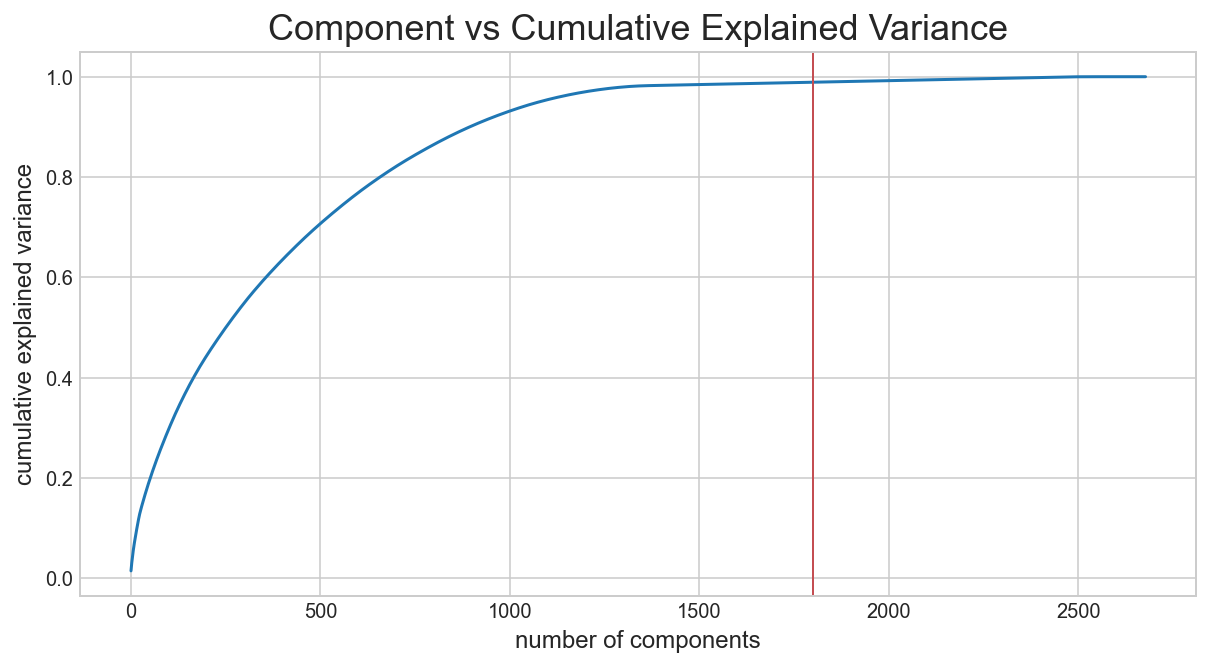

In [541]:
plt.figure(figsize=(10,5))
plt.title("Component vs Cumulative Explained Variance", fontsize=18)
graph = sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components', fontsize=12)
plt.ylabel('cumulative explained variance', fontsize=12);
graph.axvline(x=1800, lw=1, color='r');

We observe from the red vertical line on the plot above that the cumulative explained variance reaches a plateau at around 1,800 principle components or so. In other words, there is hardly any significant change in variance caused after we reach 1,800 principle components.

To lessen the overfitting of our model and accelerate model fitting, we reduce the number of features to the first 1,800 principle components.

In [513]:
# Reduce the number of principle components (i.e features)
comp_limit = 1800
X_train = X_train.iloc[:,:comp_limit]
X_val = X_val.iloc[:,:comp_limit]
X_test = X_test.iloc[:,:comp_limit]

In [514]:
X_train.shape, X_val.shape, X_test.shape

((2678, 1800), (831, 1800), (986, 1800))

## Randomised search for optimal classifier parameters

To manage the total time and resources used to tune the classifier parameters, we use the RandomizedSearchCV to randomly select parameters from the specified ranges of parameters to give the best 5-fold cross-validated accuracy score on the training dataset, with a maximum of 10 iterations. We specify the range of parameters for each classifer based on experience and past results of running the RandomizedSearchCV.

We select the best classifier as the one with the highest balanced (weighted) accuracy score on the **validation dataset**.

In [515]:
def model_func(layer_one_neurons=1000, layer_one_dropout=0.2,
               layer_two_neurons=500, layer_two_dropout=0.2, opt_learning_rate=0.001):

    model = Sequential()

    model.add(Dense(layer_one_neurons, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(layer_one_dropout))

    model.add(Dense(layer_two_neurons, activation='relu'))
    model.add(Dropout(layer_two_dropout))

    model.add(Dense(9,activation='softmax'))

    Ad = optimizers.Adam(learning_rate=opt_learning_rate,
                         beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=Ad,
                  metrics=['accuracy'], weighted_metrics=['accuracy'])
    return model

In [516]:
# We have selected a range of candidate classifiers
estimators = {
    'dtree': DecisionTreeClassifier(random_state=42), # Decision Tree Classifier
    'gnb': GaussianNB(), # Gaussian Naive Bayes Classifier
    'etree': ExtraTreesClassifier(random_state=42), # Extra Trees Classifier
    'knn': KNeighborsClassifier(), # K-nearest Neighbours Classifier
    'nn': KerasClassifier(build_fn=model_func, epochs=10, verbose=0), # Forward Neural Network Classifier
    'svc': SVC(random_state=42), # Support Vector Classifier
    'rf': RandomForestClassifier(random_state=42), # Random Forest Classifier
    'ada': AdaBoostClassifier(random_state=42), # ADABoost Classifier
    'lr': LogisticRegression(random_state=42) # Logistic Regression Classifier
}.items()

In [517]:
params = {
    'dtree': {
        'dtree__criterion': ['gini', 'entropy'],
        'dtree__splitter': ['best', 'random'],
        'dtree__min_samples_split': np.linspace(2, 10, num=5, dtype='int'),
        'dtree__min_samples_leaf': np.linspace(1, 10, num=5, dtype='int'),
        'dtree__max_features': ['auto', 'sqrt', 'log2', None],
        'dtree__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'gnb': {
        'gnb__var_smoothing': np.logspace(-9, -1, num=20)
    },
    'etree': {
        'etree__n_estimators': np.linspace(100, 200, num=10, dtype='int'),
        'etree__criterion': ['gini', 'entropy'],
        'etree__min_samples_split': np.linspace(2, 10, num=5, dtype='int'),
        'etree__min_samples_leaf': np.linspace(1, 10, num=5, dtype='int'),
        'etree__max_features': ['auto', 'sqrt', 'log2', None],
        'etree__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'knn': {
        'knn__n_neighbors': np.linspace(5, 20, num=10, dtype='int'),
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'knn__leaf_size': np.linspace(30, 50, num=10, dtype='int'),
        'knn__p': [1, 2],
        'knn__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'nn': {
        'nn__layer_one_neurons': np.linspace(500, X_train.shape[1], num=10, dtype='int').tolist(),
        'nn__layer_one_dropout': np.linspace(0.1, 0.5, num=5).tolist(),
        'nn__layer_two_neurons' : np.linspace(200, 1000, num=10, dtype='int').tolist(),
        'nn__layer_two_dropout': np.linspace(0.1, 0.5, num=5).tolist(),
        'nn__opt_learning_rate' : np.logspace(-3, -1, num=5).tolist()
    },
    'svc': {
        'svc__C': np.logspace(-3, 3, num=10),
        'svc__gamma': ['scale', 'auto'],
        'svc__kernel': ['linear','poly', 'rbf', 'sigmoid'],
        'svc__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'rf': {
        'rf__n_estimators': np.linspace(100, 200, num=10, dtype='int'),
        'rf__criterion': ['gini', 'entropy'],
        'rf__min_samples_split': np.linspace(2, 10, num=5, dtype='int'),
        'rf__min_samples_leaf': np.linspace(1, 10, num=5, dtype='int'),
        'rf__max_features': ['auto', 'sqrt', 'log2', None],
        'rf__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'ada': {
        'ada__n_estimators': np.linspace(50, 200, num=10, dtype='int'),
        'ada__learning_rate': np.linspace(1, 5, num=9),
        'ada__algorithm': ['SAMME', 'SAMME.R']
    },
    'lr': {
        # 'liblinear' solver has been excluded as a potential solver as it cannot learn a true multinomial
        # (multiclass) model; instead, the optimization problem is decomposed in a “one-vs-rest”
        # fashion so separate binary classifiers are trained for all classes.
        'lr__penalty': ['l1', 'l2', 'elasticnet'],
        'lr__C': np.logspace(-3, 3, num=10),
        'lr__class_weight': ['balanced'], # 'balanced' will help to deal with our imbalanced classes
        'lr__solver': ['newton-cg', 'lbfgs', 'sag','saga'], 
        'lr__multi_class': ['multinomial'],
        'lr__l1_ratio': np.linspace(0, 1, num=9),
        'lr__max_iter': [500]
    }
}

We now use RandomizedSearchCV to select the optimal parameters for each classifier that produces the best 5-fold cross-validation balanced accuracy score based on the training dataset.

In [518]:
%%time
# initialise empty lists to store information later
models = []
parameters = []
best_score = []
train_bal_f1_score = []
val_bal_f1_score = []
train_bal_accuracy = []
val_bal_accuracy = []

for k,v in estimators:
    start = time.time()
    pipe = Pipeline([(k,v)])
    param = params[k]
    randomsearch = RandomizedSearchCV(
        n_iter = 10, # we set a max. of 10 iterations
        estimator = pipe,
        random_state = 42,
        param_distributions = param,
        verbose = 1,
        cv = 5, # 5-fold cross-validation
        n_jobs = None, # Avoid concurrent job execution
        return_train_score= True,
        scoring = 'balanced_accuracy' # cater for class imbalance
    )

    now = datetime.datetime.now()
    print ("Model: ", k)
    print ("Started fitting at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
    
    randomsearch.fit(X_train, y_train)
    
    model = randomsearch.best_estimator_
    cv_score = randomsearch.cv_results_
    best_params = randomsearch.best_params_

    # predict y
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # print results
    print ("Fitting duration (h:m:s): {}".format(str(datetime.timedelta(seconds=time.time()-start))))
    print ("Best parameters:", best_params)
    print ("Best cross-validation balanced accuracy score:", randomsearch.best_score_)
    print ("Training set balanced F1 score:", f1_score(y_train, y_train_pred, average='weighted'))
    print ("Validation set balanced F1 score:", f1_score(y_val, y_val_pred, average='weighted'))
    print ("Training set balanced accuracy:", balanced_accuracy_score(y_train,y_train_pred))
    print ("Validation set balanced accuracy:", balanced_accuracy_score(y_val,y_val_pred))
    print ("")
    
    # append info to list
    models.append(k)
    best_score.append(randomsearch.best_score_)
    parameters.append(best_params)
    train_bal_f1_score.append(f1_score(y_train,y_train_pred, average='weighted'))
    val_bal_f1_score.append(f1_score(y_val,y_val_pred, average='weighted'))
    train_bal_accuracy.append(balanced_accuracy_score(y_train,y_train_pred))
    val_bal_accuracy.append(balanced_accuracy_score(y_val,y_val_pred))

Model:  dtree
Started fitting at: 2020-04-15 16:59:38
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.4s finished


Fitting duration (h:m:s): 0:00:09.947553
Best parameters: {'dtree__splitter': 'best', 'dtree__min_samples_split': 2, 'dtree__min_samples_leaf': 7, 'dtree__max_features': 'sqrt', 'dtree__criterion': 'entropy', 'dtree__class_weight': 'balanced'}
Best cross-validation balanced accuracy score: 0.5243091402063582
Training set balanced F1 score: 0.6781466777304318
Validation set balanced F1 score: 0.3680921951054686
Training set balanced accuracy: 0.7842085608339756
Validation set balanced accuracy: 0.3305785348091764

Model:  gnb
Started fitting at: 2020-04-15 16:59:48
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   48.2s finished


Fitting duration (h:m:s): 0:00:49.505518
Best parameters: {'gnb__var_smoothing': 1e-09}
Best cross-validation balanced accuracy score: 0.5173986746673948
Training set balanced F1 score: 0.6118225729105543
Validation set balanced F1 score: 0.35296478203769505
Training set balanced accuracy: 0.6822967654140628
Validation set balanced accuracy: 0.33788838980879976

Model:  etree
Started fitting at: 2020-04-15 17:00:38
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.3min finished


Fitting duration (h:m:s): 0:07:21.733912
Best parameters: {'etree__n_estimators': 100, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 5, 'etree__max_features': None, 'etree__criterion': 'gini', 'etree__class_weight': 'balanced'}
Best cross-validation balanced accuracy score: 0.6841478546931968
Training set balanced F1 score: 0.9610404049513939
Validation set balanced F1 score: 0.6079006068759258
Training set balanced accuracy: 0.9751177857639005
Validation set balanced accuracy: 0.5279319221734262

Model:  knn
Started fitting at: 2020-04-15 17:08:00
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 16.2min finished


Fitting duration (h:m:s): 0:16:51.436896
Best parameters: {'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 8, 'knn__metric': 'manhattan', 'knn__leaf_size': 43, 'knn__algorithm': 'kd_tree'}
Best cross-validation balanced accuracy score: 0.6173328167027524
Training set balanced F1 score: 1.0
Validation set balanced F1 score: 0.5206970981840054
Training set balanced accuracy: 1.0
Validation set balanced accuracy: 0.4246212736462765

Model:  nn
Started fitting at: 2020-04-15 17:24:51
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 23.6min finished


Fitting duration (h:m:s): 0:24:29.728513
Best parameters: {'nn__opt_learning_rate': 0.001, 'nn__layer_two_neurons': 555, 'nn__layer_two_dropout': 0.1, 'nn__layer_one_neurons': 1800, 'nn__layer_one_dropout': 0.30000000000000004}
Best cross-validation balanced accuracy score: 0.6361028110209623
Training set balanced F1 score: 0.9735170981877105
Validation set balanced F1 score: 0.6045010553691839
Training set balanced accuracy: 0.9739034017943042
Validation set balanced accuracy: 0.5021744532384299

Model:  svc
Started fitting at: 2020-04-15 17:49:21
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 55.3min finished


Fitting duration (h:m:s): 0:56:15.431793
Best parameters: {'svc__kernel': 'linear', 'svc__gamma': 'scale', 'svc__class_weight': 'balanced', 'svc__C': 0.001}
Best cross-validation balanced accuracy score: 0.6953439915054407
Training set balanced F1 score: 0.9552437613894182
Validation set balanced F1 score: 0.613043851876835
Training set balanced accuracy: 0.9726855604333485
Validation set balanced accuracy: 0.5112672100284468

Model:  rf
Started fitting at: 2020-04-15 18:45:36
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 33.8min finished


Fitting duration (h:m:s): 0:34:19.431958
Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced'}
Best cross-validation balanced accuracy score: 0.6918387675578936
Training set balanced F1 score: 0.9128202331612207
Validation set balanced F1 score: 0.5977316402272247
Training set balanced accuracy: 0.9312674787266177
Validation set balanced accuracy: 0.5197686515457345

Model:  ada
Started fitting at: 2020-04-15 19:19:56
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 58.8min finished


Fitting duration (h:m:s): 1:02:04.989971
Best parameters: {'ada__n_estimators': 133, 'ada__learning_rate': 1.5, 'ada__algorithm': 'SAMME'}
Best cross-validation balanced accuracy score: 0.31846263373037725
Training set balanced F1 score: 0.3982570875529424
Validation set balanced F1 score: 0.3011965505324236
Training set balanced accuracy: 0.3593015533716962
Validation set balanced accuracy: 0.2249225670232178

Model:  lr
Started fitting at: 2020-04-15 20:22:01
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Deta

C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

Fitting duration (h:m:s): 0:48:56.375369
Best parameters: {'lr__solver': 'saga', 'lr__penalty': 'l2', 'lr__multi_class': 'multinomial', 'lr__max_iter': 500, 'lr__l1_ratio': 0.0, 'lr__class_weight': 'balanced', 'lr__C': 215.44346900318823}
Best cross-validation balanced accuracy score: 0.695535305151927
Training set balanced F1 score: 0.9093063639768116
Validation set balanced F1 score: 0.6180358055618196
Training set balanced accuracy: 0.93346333864416
Validation set balanced accuracy: 0.5401689239197451

Wall time: 4h 11min 19s


C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Selection of Baseline Model

In [519]:
# Produce a summary table of the tuned classifiers
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'Best cross-validation balanced accuracy score': best_score,
    'Training set balanced F1 score': train_bal_f1_score,
    'Validation set balanced F1 score': val_bal_f1_score,
    'Training set balanced accuracy': train_bal_accuracy,
    'Validation set balanced accuracy': val_bal_accuracy
    })

pd.set_option('display.max_colwidth', None)
summary.sort_values('Validation set balanced accuracy', ascending=False).reset_index(drop=True)

,model,parameters,Best cross-validation balanced accuracy score,Training set balanced F1 score,Validation set balanced F1 score,Training set balanced accuracy,Validation set balanced accuracy
0,lr,"{'lr__solver': 'saga', 'lr__penalty': 'l2', 'lr__multi_class': 'multinomial', 'lr__max_iter': 500, 'lr__l1_ratio': 0.0, 'lr__class_weight': 'balanced', 'lr__C': 215.44346900318823}",0.695535,0.909306,0.618036,0.933463,0.540169
1,etree,"{'etree__n_estimators': 100, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 5, 'etree__max_features': None, 'etree__criterion': 'gini', 'etree__class_weight': 'balanced'}",0.684148,0.961040,0.607901,0.975118,0.527932
2,rf,"{'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced'}",0.691839,0.912820,0.597732,0.931267,0.519769
3,svc,"{'svc__kernel': 'linear', 'svc__gamma': 'scale', 'svc__class_weight': 'balanced', 'svc__C': 0.001}",0.695344,0.955244,0.613044,0.972686,0.511267
4,nn,"{'nn__opt_learning_rate': 0.001, 'nn__layer_two_neurons': 555, 'nn__layer_two_dropout': 0.1, 'nn__layer_one_neurons': 1800, 'nn__layer_one_dropout': 0.30000000000000004}",0.636103,0.973517,0.604501,0.973903,0.502174
5,knn,"{'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 8, 'knn__metric': 'manhattan', 'knn__leaf_size': 43, 'knn__algorithm': 'kd_tree'}",0.617333,1.000000,0.520697,1.000000,0.424621
6,gnb,{'gnb__var_smoothing': 1e-09},0.517399,0.611823,0.352965,0.682297,0.337888
7,dtree,"{'dtree__splitter': 'best', 'dtree__min_samples_split': 2, 'dtree__min_samples_leaf': 7, 'dtree__max_features': 'sqrt', 'dtree__criterion': 'entropy', 'dtree__class_weight': 'balanced'}",0.524309,0.678147,0.368092,0.784209,0.330579
8,ada,"{'ada__n_estimators': 133, 'ada__learning_rate': 1.5, 'ada__algorithm': 'SAMME'}",0.318463,0.398257,0.301197,0.359302,0.224923


Based on the table above, we observe the following:
- The best performing model is the multinomial Logistic Regression Classifier with a validation dataset balanced accuracy score of `0.540169` which is more than 10% better than our baseline accuracy score of `0.286962`. It also has a balanced F1 score of `0.618036`.
- For all the models, the balanced F1 and accuracy scores for the validation dataset are lower that the respective scores on the training dataset -- this indicates that all our models tend to be overfitted.

<div class="alert alert-block alert-info">
We consider our baseline model to be the <b>Logistic Regression Classifier</b> with the parameters shown above, trained on <b>TfidfVectorizer</b> weighted word frequencies.
</div>

## Further Exploration of Baseline Model

Multinomial logistic regression is a classification method that generalises logistic regression to multi-class problems, i.e. with more than two possible discrete outcomes. To further explore this classifier, we first instantiate the baseline classifier based on the best parameters found above, and then fit it on the validation dataset.

In [520]:
# We instantiate the baseline classifier based on the best parameters found above
baseline_clf = LogisticRegression(verbose=1, n_jobs=4, random_state=42, solver='saga', penalty='l2',
                                  multi_class='multinomial', l1_ratio=0,
                                  class_weight='balanced', C=215.44346900318823)

In [521]:
%%time
# Fit the best classifier on the validation dataset
baseline_clf.fit(X_val, y_val)

C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 6 seconds
Wall time: 6.52 s


C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.3s finished


LogisticRegression(C=215.44346900318823, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0,
                   max_iter=100, multi_class='multinomial', n_jobs=4,
                   penalty='l2', random_state=42, solver='saga', tol=0.0001,
                   verbose=1, warm_start=False)

In [46]:
# Create a joblib dump of the fitted baseline model
# For use in PythonAnywhere back-end

# dump(baseline_clf, "../web/backend_pythonanywhere/baseline_clf.joblib")

['baseline_clf.joblib']

### Logistic Regression Coefficients

We now print out the top 5 principle components and their coefficients, for each of the 9 classes. A one-unit change in each principle component means that the prediction for the respective class is $e^{c}$ times as likely, where c is the coefficient value shown.

In [522]:
for cl in range(0,9):
    scores = pd.DataFrame(baseline_clf.coef_, columns=X_train.columns)
    print("\n---------------------------------------------------------------------------")
    print("Top 5 principle components and coefficient values for prediction of class {}".format(cl+1))
    print("---------------------------------------------------------------------------")
    print(np.exp(scores.loc[cl,np.exp(scores.loc[cl,:].sort_values(ascending=False)).head(5).index.tolist()]))


---------------------------------------------------------------------------
Top 5 principle components and coefficient values for prediction of class 1
---------------------------------------------------------------------------
PC1278    1.014369
PC48      1.011746
PC331     1.011560
PC1274    1.011378
PC1205    1.011308
Name: 0, dtype: float64

---------------------------------------------------------------------------
Top 5 principle components and coefficient values for prediction of class 2
---------------------------------------------------------------------------
PC46      1.021486
PC49      1.017763
PC55      1.016718
PC29      1.015170
PC1078    1.014920
Name: 1, dtype: float64

---------------------------------------------------------------------------
Top 5 principle components and coefficient values for prediction of class 3
---------------------------------------------------------------------------
PC1361    1.019158
PC146     1.015251
PC1257    1.013647
PC312     1.012228

As expected:
1. The top 5 principle components for each class are mostly different from one another. This is a direct consequence of performing PCA - we obtain principle components which are mostly independent of one another.
2. It is not straightforward to interpret what each principle component means, in relation to the set of the features in the original datasets prior to performing PCA. In other words, we cannot easily identify what set of word(s) each principle component refers to. We accept this, as we have benefitted from faster model training times; our problem statement is focused on coming up with a classifier, and not to understand what words/phrases are key to predicting which classes.

### ROC curves and metrics for Validation Dataset

In [523]:
# Generate predictions for the validation data based on our baseline model
y_val_pred = baseline_clf.predict(X_val)

In [524]:
# Binarize the output
y_train_binarized = label_binarize(y_train, classes=list(np.unique(y)))
y_val_pred_binarized = label_binarize(y_val_pred, classes=list(np.unique(y)))
n_classes = len(np.unique(y))

To come up with actual scores that can be used for ROC calculation, we use the OneVsRestClassifier coupled with a SVC (C-Support Vector) Classifier to fit the training dataset so that we can obtain the distances of each sample from the decision boundary for each class.

In [525]:
%%time
now = datetime.datetime.now()
print ("Started fitting at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
# We obtain the distances of each sample from the decision boundary for each class
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42, verbose=1), n_jobs=2)
y_score = classifier.fit(X_train, y_train_binarized).decision_function(X_val)

Started fitting at: 2020-04-15 21:11:04
Wall time: 2min 11s


In [526]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # we compare our predicted labels for the validation dataset and the actual validation dataset labels
    # first parameter of roc_curve is y_true, and second parameter is y_score
    fpr[i], tpr[i], _ = roc_curve(y_val_pred_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_pred_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

We plot ROC curves for all the 9 classes.

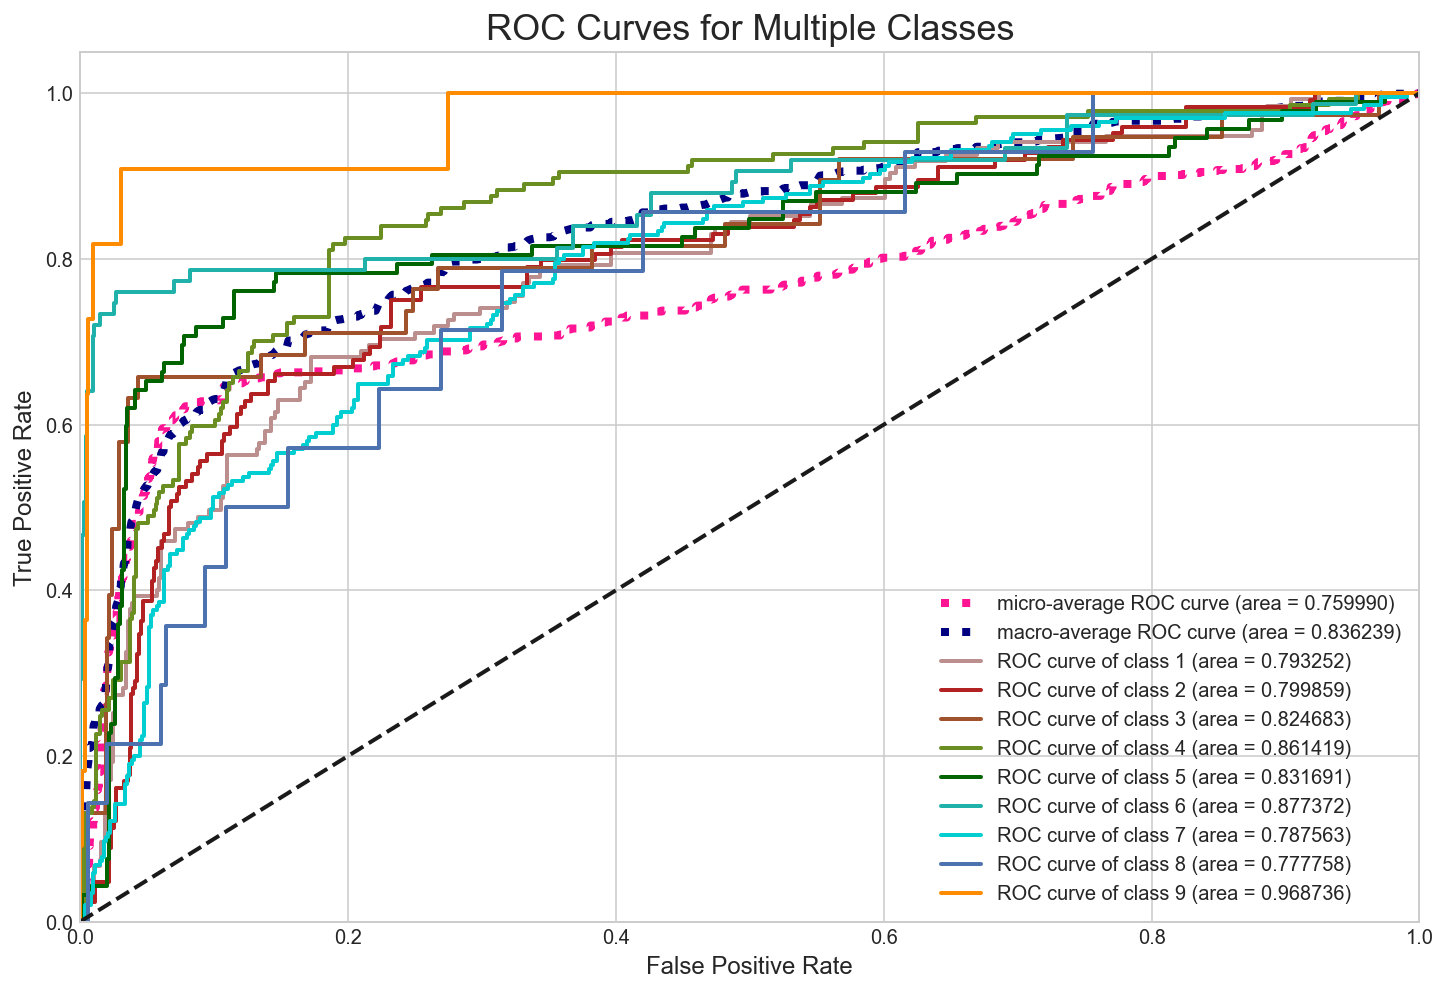

In [542]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.6f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.6f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

lw=2
colors = cycle(['rosybrown', 'firebrick', 'sienna', 'olivedrab', 'darkgreen',\
                'lightseagreen', 'darkturquoise', 'b', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Multiple Classes', fontsize=18)
plt.legend(loc="lower right")
plt.show()

The Receiver Operaitng Characteristic (ROC) Curve is a probability curve and the Area Under Curve (AUC) represents the degree of separability i.e. the capability of the model in distinguishing between classes. The higher the AUC, the better the model is at predicting each class correctly, based on the validation data, in this case. 

We note from the ROC curves and AUC scores ('area' metric) in the plot above that the micro-average AUC score is `0.759990`.

Based on the observer ROC curves and AUC scores for all the classes, the model has performed reasonably well.

### Confusion Matrix

We plot a confusion matrix can be used to evaluate the quality of the output of our classifier.

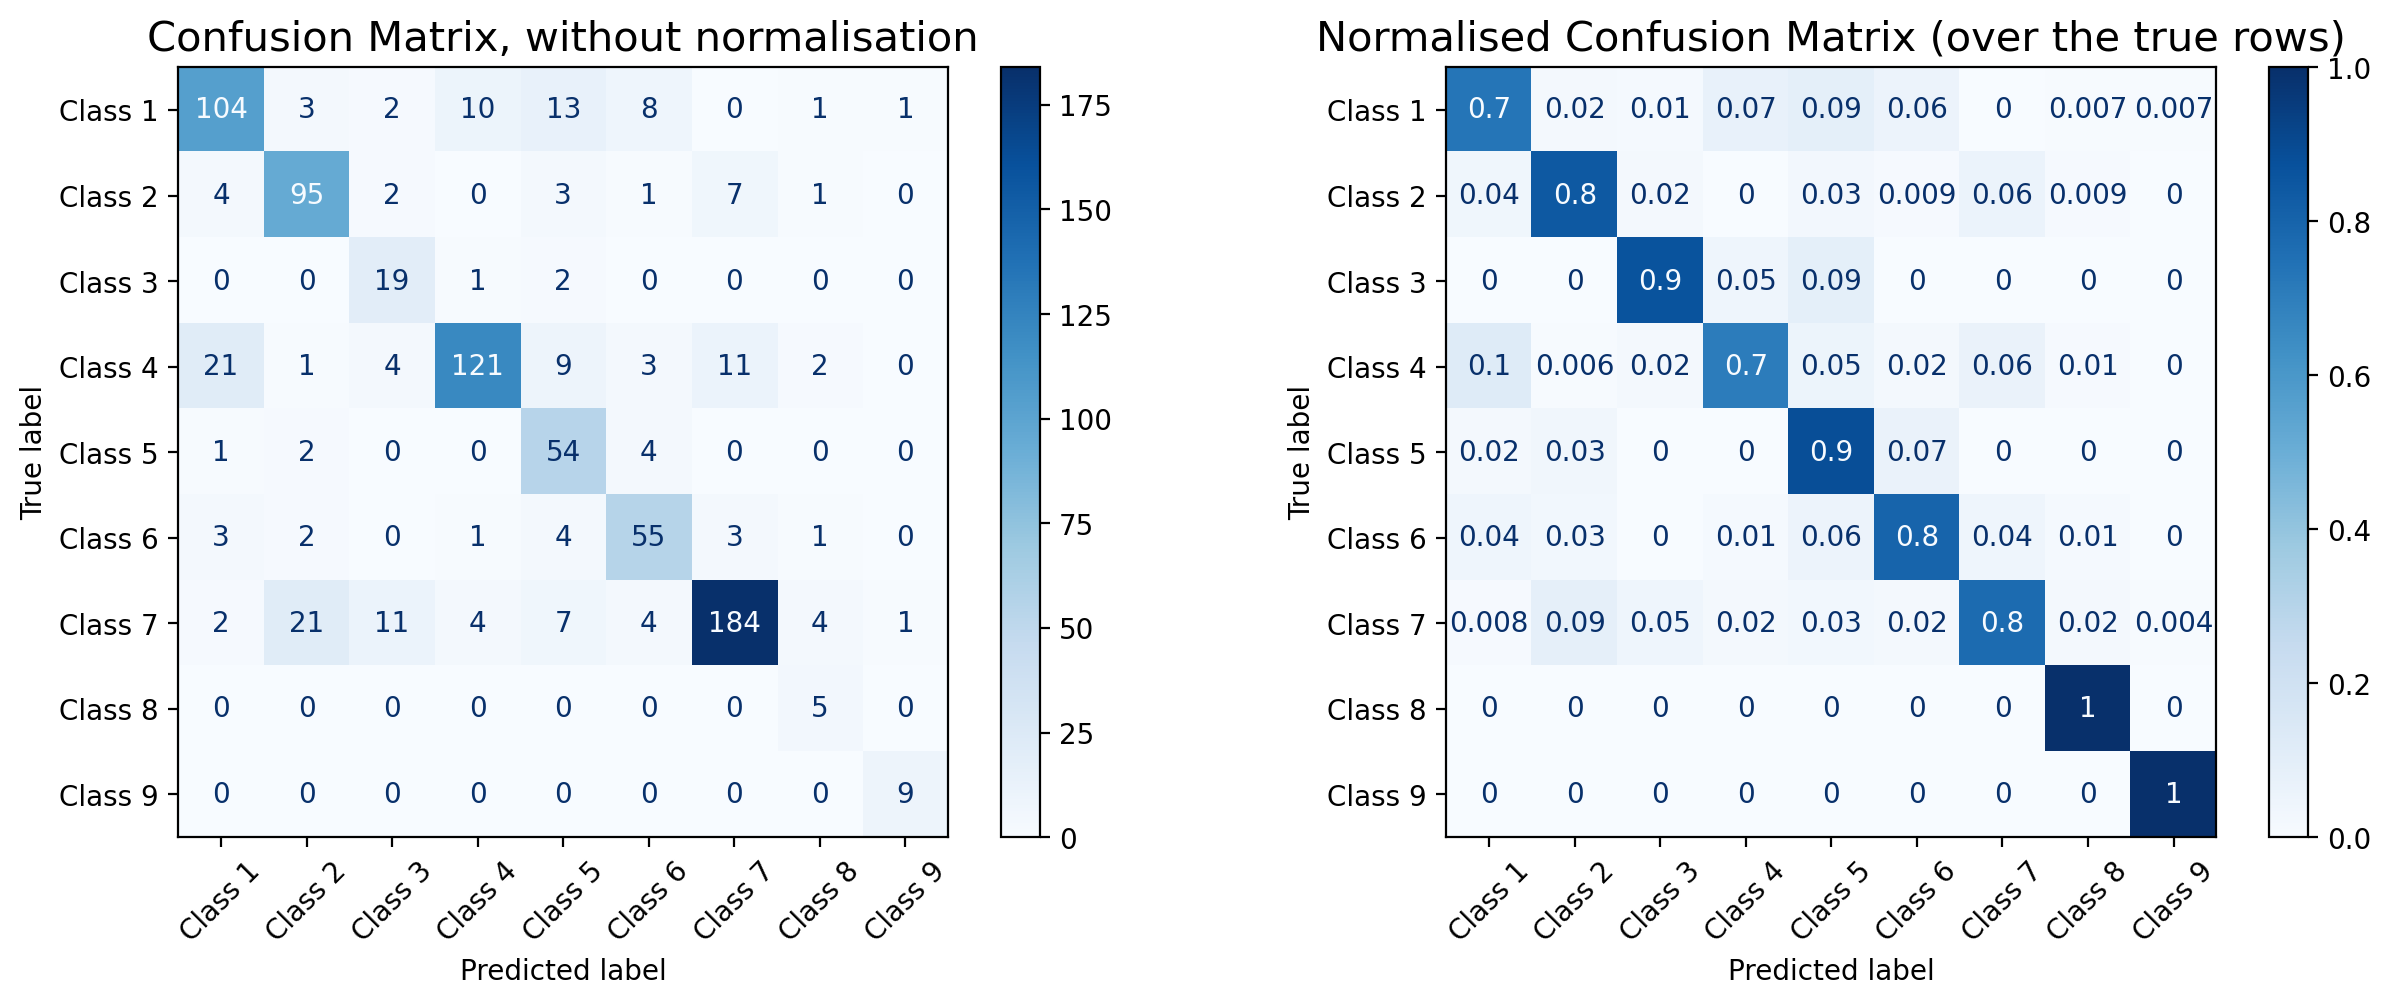

In [544]:
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
disp = plot_confusion_matrix(baseline_clf, X_val, y_val,
                             display_labels=['Class '+str(i+1) for i in range(0,9)],
                             cmap=plt.cm.Blues, values_format='.4g', xticks_rotation=45,
                             normalize=None, ax=ax1)
disp = plot_confusion_matrix(baseline_clf, X_val, y_val,
                             display_labels=['Class '+str(i+1) for i in range(0,9)],
                             cmap=plt.cm.Blues, values_format='.1g', xticks_rotation=45,
                             normalize='true', ax=ax2)
ax1.set_title("Confusion Matrix, without normalisation", fontsize=15)
ax2.set_title("Normalised Confusion Matrix (over the true rows)", fontsize=15)
plt.show();  

As shown above, the diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions. In particular the ideal diagonal values for the normalised confusion matrix are 1.

The normalised confusion matrix, in particular, shows diagonal values that are 0.7 and above, which is a visual indicator that that our baseline model has done a reasonably good job.

### Comparison of Frequency Distributions

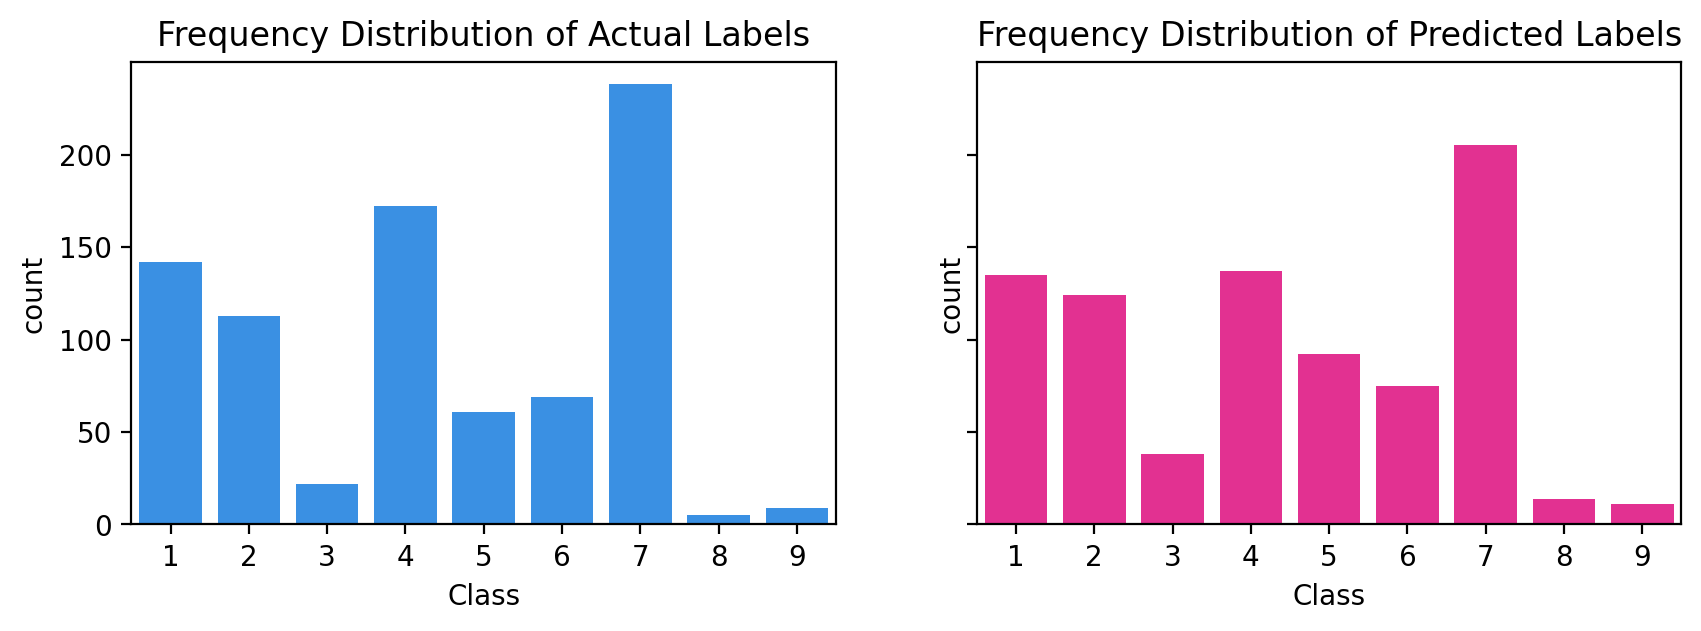

In [546]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
sns.countplot(y_val, color="dodgerblue", ax=axes[0])
sns.countplot(y_val_pred, color="deeppink", ax=axes[1]);
axes[0].set_title("Frequency Distribution of Actual Labels")
axes[1].set_title("Frequency Distribution of Predicted Labels")
axes[0].set_xlabel("Class")
axes[1].set_xlabel("Class");

A comparison of the two frequency distributions shows that:
- The relative frequencies of the classes has been generally preserved in the predictions, except for classes 5 and 8, which appear to be 'over-predicted'.
- The baseline model has also predicted relatively fewer number of class '7'.

## Summary of Baseline Model

We have successfully built a baseline model comprising a Logistic Regression Classifier that has a balanced accuracy score (`0.540169`) on the validation dataset that is more than 10% better than the baseline accuracy of `0.286962`. The classifier has been trained on TfidfVectorizer weighted word frequencies. It has a balanced F1 score of `0.618036` and a micro-average AUC score of `0.759990`. 

Our training and validation datasets are imbalanced, but we have adopted the ADASYN oversampling method to increase the number of samples for the 3 most infrequent classes. We have also used Principle Component Analysis (PCA) to greatly reduce the number of features for our model from over 76,000 to just 1,800. Whilst this has reduced our model fitting times, we do lose out on the ability to interpret the features that remain. We also concede that despite our efforts to perform feature engineering and oversampling, our baseline model is still quite overfitted, as shown by its poorer performance on the validation dataset compared to the training dataset.  

In Notebook 4, we further explore the use of various word embeddings to see if we can come up with an alternative model that outperforms the baseline model.

## Data Export (for Kaggle Submission)

In [530]:
# Generate predictions
y_test_pred = baseline_clf.predict(X_test)

In [531]:
y_test_pred.shape

(986,)

In [532]:
# Restore the 'id' column since we need this for the Kaggle submission
test_pred = pd.concat([test['id'], pd.DataFrame(y_test_pred, columns=['class'])], axis=1)

In [533]:
# Verify that we have a mix of predictions for variation classes
test_pred['class'].value_counts()

2    252
7    200
4    130
1    111
9     78
8     65
5     61
6     51
3     38
Name: class, dtype: int64

In [534]:
test_pred.head()

,id,class
0,1,6
1,2,4
2,3,2
3,4,9
4,5,7


In [535]:
test_pred.to_csv("../assets/test_pred.csv", index=False)

---

In [536]:
# For tracking the execution time for the entire notebook
print ("Notebook execution duration (h:m:s): {}".format(str(datetime.timedelta(seconds=time.time()-notebook_start))))

Notebook execution duration (h:m:s): 4:20:41.452638
